### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


ts = pd.read_csv('data.csv')
print('Series shape: ', ts.shape)
print(ts.head())

Series shape:  (385566, 2)
                    dt      MW
0  2011-01-01 00:00:00  3416.0
1  2011-01-01 00:15:00  4755.0
2  2011-01-01 00:30:00  4939.0
3  2011-01-01 00:45:00  4939.0
4  2011-01-01 01:00:00  4998.0


Представленные данные имеет периодичность в 15 минут. Сгруппируем данные с периодом в месяц, так как изначальный ряд имеет значимые колебания и это отразится на неэффективном прогнозировании.

In [2]:
ts['dt'] = pd.to_datetime(ts['dt'])
ts = ts.set_index('dt') 
monthly_summary = ts.resample('M').sum()
monthly_summary.head()

,MW
dt,
2011-01-31,4753535.0
2011-02-28,4502270.0
2011-03-31,4948915.0
2011-04-30,4795377.0
2011-05-31,5590865.0


Так как временной ряд был агрегирован путем сумирования значений по интервалу, применим преобразование Бокса-Кокса, чтобы уменьшить размах дисперсии значений временного ряда. Также проверим исходный ряд на стационарность с помощью теста Дики-Фулера. 

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import warnings 

warnings.filterwarnings('ignore')

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -0.966711
p-value                          0.765211
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


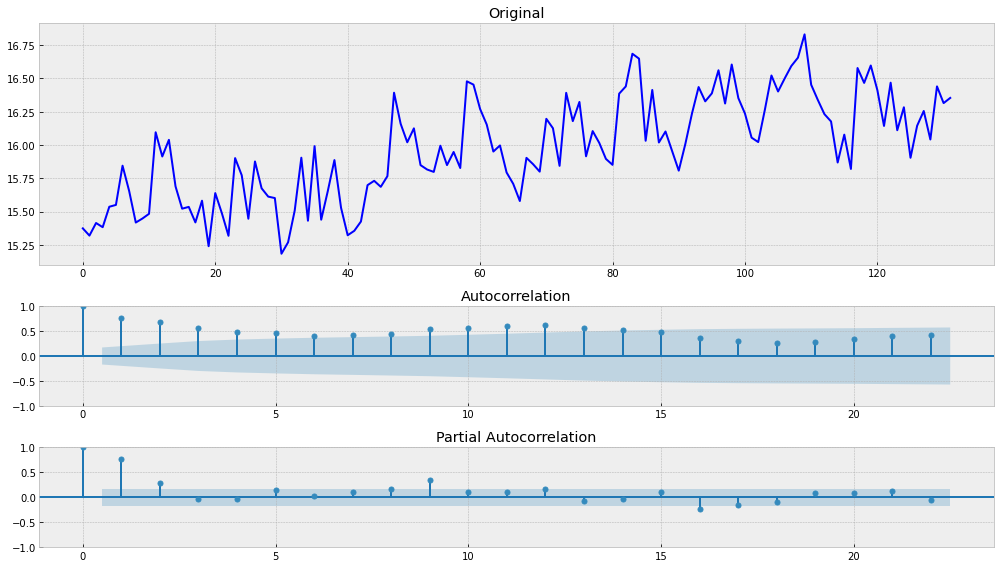

In [4]:
series = boxcox(monthly_summary['MW'], 0)
tsplot(series)

Временной ряд нестационарный, имеются изменения и в дисперсии и среднем временного ряда. Имеется возрастающий тренд.

Разложим исходный ряд на его декомпозицию по характеристиками.

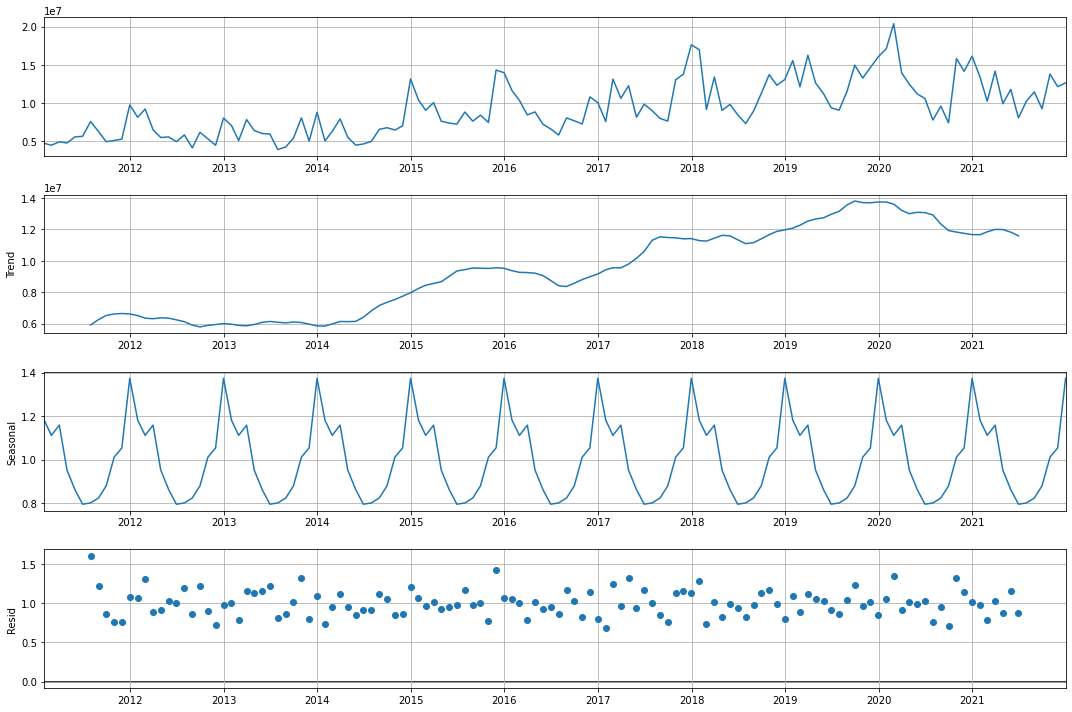

In [5]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL

plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams.update({"axes.grid" : True})

monthly_summary = ts.resample('M').sum()
ts_decomposed = seasonal_decompose(monthly_summary, model='multiplicative')
ts_decomposed.plot();

Как видно, с начала ведения сбора данных, производство ветряной электроэнергии в Германии увеличилось. Имеется восходящий тренд сквозь года, количество вырабатываемой энергии с 2011 года по 2020 год увеличилось в два раза, с 2020 года пошел нисходящий тренд по производству. На графике сезонности стоит заметить, что количество энергии в осенне-зимний период максимальное, в летний период сведено к минимуму.

Создадим датасет из значений временного ряда. Обогатим его с помощью сдвигов на лаги. Также добавим категориальный признак - индекс месяца, и бинарный признак "холодно или горячо", которые указывает на отопительный сезон. 

In [6]:
data = monthly_summary.copy()
data.columns = ['y']

for i in range(3, 12):
    data["lag_{}".format(i)] = data.y.shift(i)
    

data["month"] = data.index.month
data['is_cold_or_hot'] = data.month.isin([9,10,11,12,1,2,3])*1

Разобьем выборку на тренировочную и тестовую, произведем шкалирование значений признаков к стандартным нормальным.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler


def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]

    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Модель линейной регресии

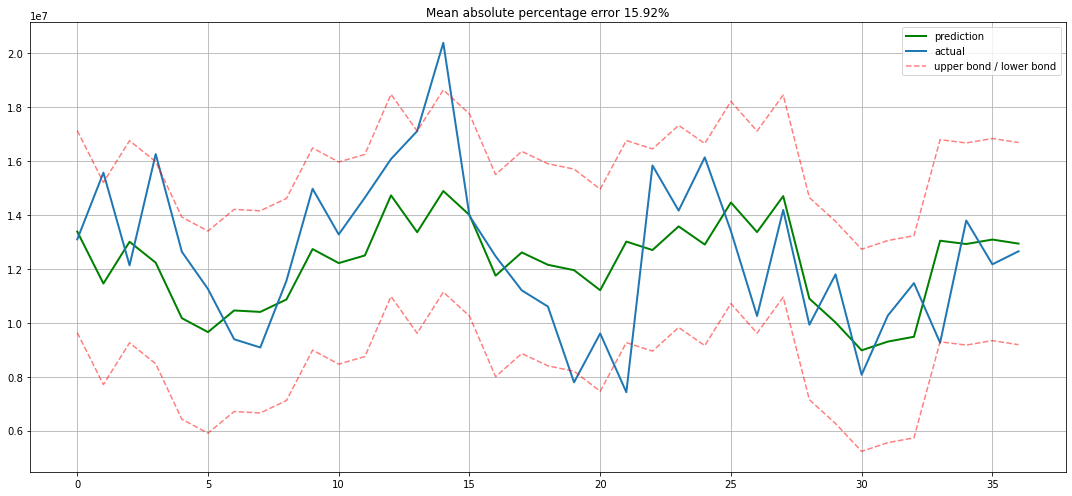

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True)

Применим регуляризацию опробовав модели Lasso, Ridge

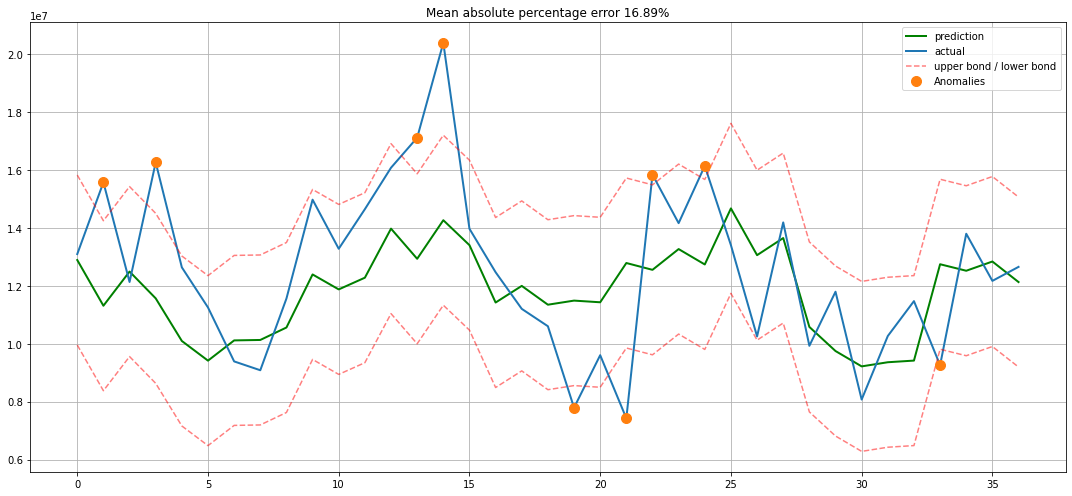

In [10]:
from sklearn.linear_model import LassoCV, RidgeCV

lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

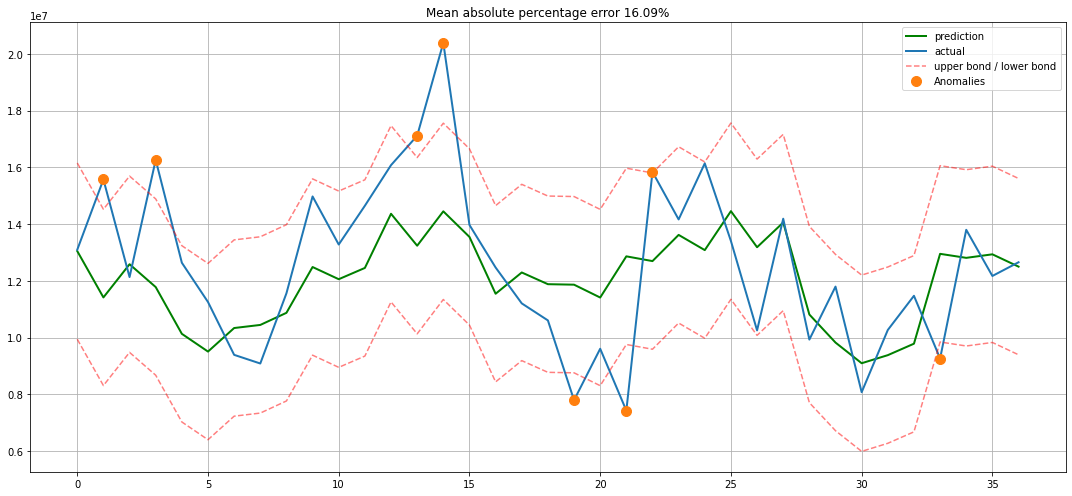

In [11]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

Адаптивный бустинг на деревьях решений

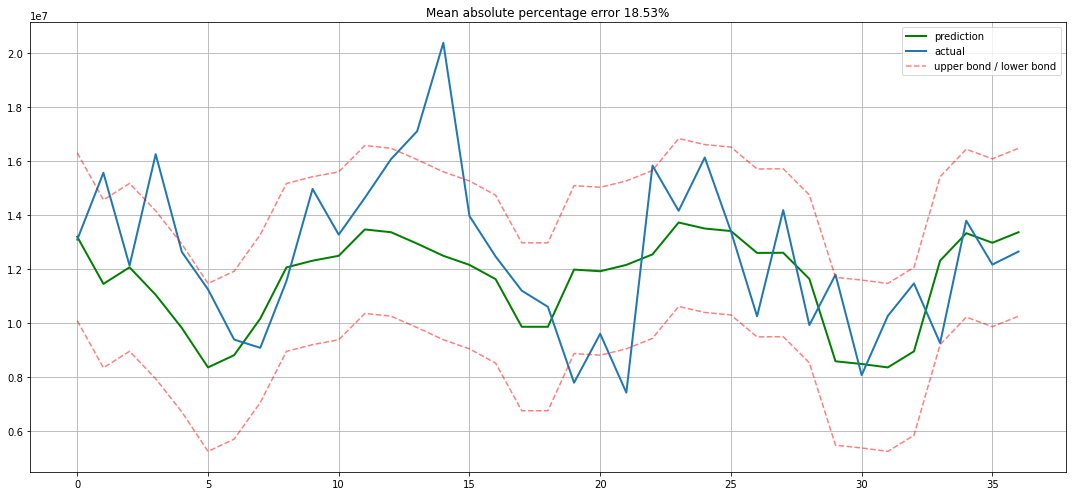

In [12]:
from sklearn.ensemble import AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train, y_train)

plotModelResults(gbr, X_train=X_train, X_test=X_test, plot_intervals=True)

Согласно метрике MAPE на тестовой выборке лучшее качество показала модель линейной регрессии. Произведем прогноз на 12 месяцев по данной модели. Будем предсказывать значение на один шаг и переподготавливать строку со сдвигом для следующего прогноза.

In [13]:
lr = LinearRegression()
lr.fit(X,y);

date_index = pd.date_range(start = '2022-01-01', periods=12, freq='M')
new_lags = [13798147.07, 12171375.01, 12654287.86]

last = list(X.iloc[-1].values[:9])
pred_list = []
for i,index in zip(range(1,13), date_index):
    if i <= 9:
        lag_feature = new_lags[:i][::-1] + last[:-i]
    else:
        lag_feature = new_lags[i-9:i][::-1]
    
    fst_feature = index.month
    sc_feature = 1 if index.month in [9,10,11,12,1,2,3] else 0
    X_pred = np.array([lag_feature + [fst_feature] + [sc_feature]])

    y_pred = lr.predict(X_pred)[0]
    new_lags.append(y_pred)
    pred_list.append(y_pred)
    
year_pred = pd.Series(pred_list, index = date_index)

Прогноз модели на следующие 12 месяцев

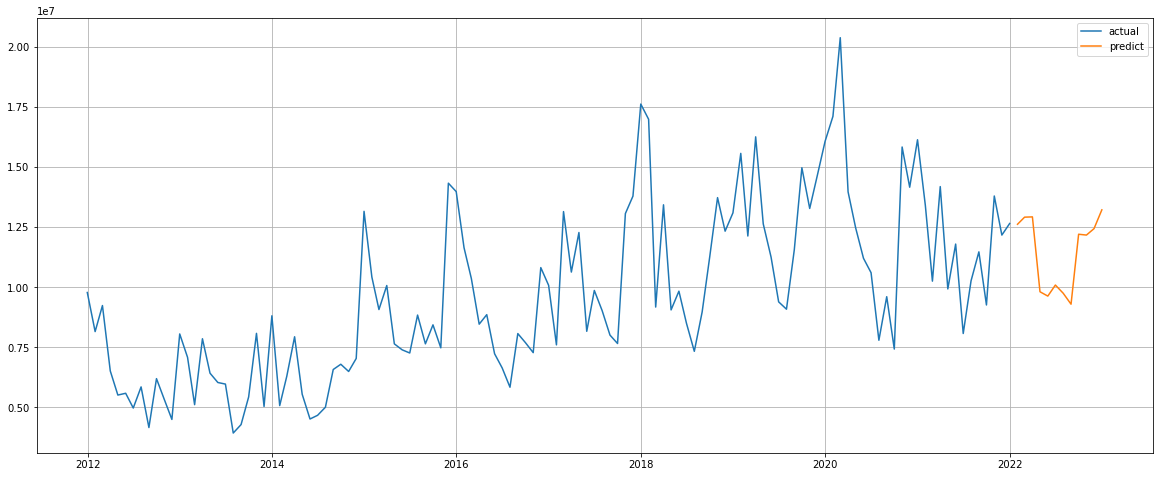

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(y, linewidth=1.5, label = 'actual')
plt.plot(year_pred, linewidth=1.5, label = 'predict')
plt.grid(True)
plt.legend()
plt.show()

Попробуем построить модель с помощью Prophet. Разобьем временной ряд на тренировочную и тестовую выборки в таком же соотношении и проверим качество на той же метрике MAPE.

In [15]:
from prophet import Prophet

df = monthly_summary.reset_index()
df.columns = ['ds', 'y']

len_test = y_test.shape[0]
train_df = df[:-len_test]

model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_df)

future = model.make_future_dataframe(periods=len_test, freq='M')
forecast = model.predict(future)

forecast.head()

21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-31,4.769990e+06,1.895797e+06,7.477649e+06,4.769990e+06,4.769990e+06,-187888.251952,-187888.251952,-187888.251952,-187888.251952,-187888.251952,-187888.251952,0.0,0.0,0.0,4.582102e+06
1,2011-02-28,4.834146e+06,1.929683e+06,7.385928e+06,4.834146e+06,4.834146e+06,-187888.251953,-187888.251953,-187888.251953,-187888.251953,-187888.251953,-187888.251953,0.0,0.0,0.0,4.646258e+06
2,2011-03-31,4.905176e+06,2.045436e+06,7.710474e+06,4.905176e+06,4.905176e+06,-76375.419465,-76375.419465,-76375.419465,-76375.419465,-76375.419465,-76375.419465,0.0,0.0,0.0,4.828801e+06
3,2011-04-30,4.973915e+06,1.878165e+06,7.317919e+06,4.973915e+06,4.973915e+06,-298599.994275,-298599.994275,-298599.994275,-298599.994275,-298599.994275,-298599.994275,0.0,0.0,0.0,4.675315e+06
4,2011-05-31,5.044945e+06,2.411018e+06,7.936474e+06,5.044945e+06,5.044945e+06,144859.590008,144859.590008,144859.590008,144859.590008,144859.590008,144859.590008,0.0,0.0,0.0,5.189804e+06


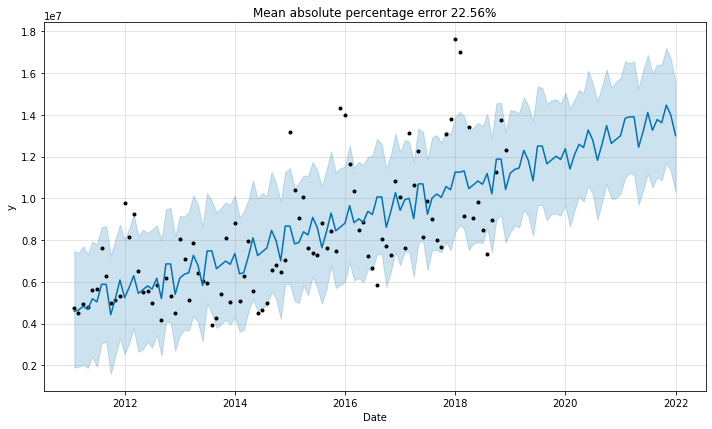

In [16]:
error = mean_absolute_percentage_error(df[-len_test:]['y'], forecast[-len_test:]['yhat'])
fig = model.plot(forecast, xlabel='Date')
plt.title("Mean absolute percentage error {0:.2f}%".format(error))
plt.show()

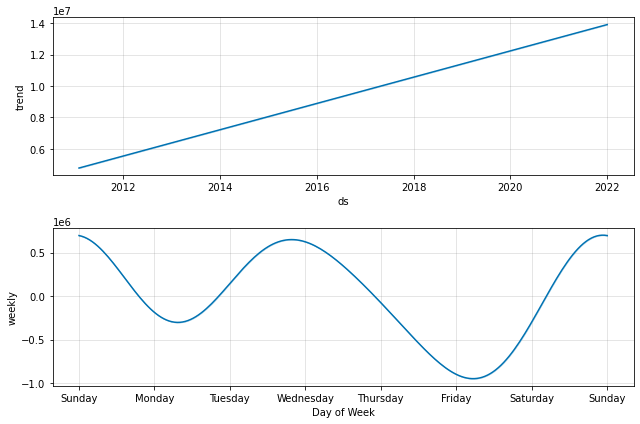

In [17]:
_ = model.plot_components(forecast)

Таким образом модель линейной регресии показала лучшее качество на тестовой выборке: 15.92 процента ошибок против 22.56. Однако стоит отметить, что модель линейной регрессии строилось на датасете в виде сдвинутых лагов, что на дистанции может давать некорректный результат.

Прогноз на 12 месяцев с помощью модели Prophet

21:23:23 - cmdstanpy - INFO - Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] done processing


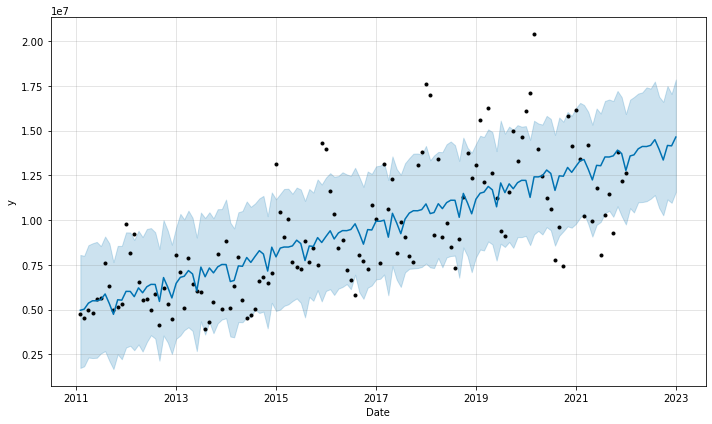

In [18]:
df = monthly_summary.reset_index()
df.columns = ['ds', 'y']

model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
model.fit(df)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast, xlabel='Date')
plt.show()